# download images to disk

here we use the planet.com api access to download imagery within a determined polygon, focusing on 
`PSScene4Band` and and the 8 month period between 2019-10-01 and 2020-05-31, inclusive.

- send a search request: 
    + one for each chosen band,
    + delimited by area of interest polygon
    + 
- collect search responses
- for each successful response:
    + get asset url
    + get asset[''] 'analytic' url
    + activate visual asset via url
    + await activation to complete
    + get location url from asset
    + run the download asset function.

In [60]:
import geojson
import json
import os # in order to access environment variables
import matplotlib.pyplot as plt
from planet import api
import requests
import time
from requests.auth import HTTPBasicAuth
import xml.etree.ElementTree as ET

In [61]:
def run_quick_search(query, item_types):
    result_dict = {}
    for item_type in item_types:
        request = api.filters.build_search_request(query, [item_type])
        try: 
            result_dict[item_type] = client.quick_search(request)
        except:
            print('item type', item_type, 'is not available')
    print('found image data for', len(result_dict.keys()), 'item types')
    return result_dict


def get_asset_url(result_object):
    features = result_object.get().get('features')
    return features['']

def ensure_activation(asset_url, asset_type):
    asset_activated = False
    while asset_activated == False:
        # Send a request to the item's assets url
        res = session.get(assets_url)

        # Assign a variable to the item's assets url response
        assets = res.json()

        # Assign a variable to the visual asset from the response
        asset_requested = assets[asset_type]

        asset_status = asset_requested["status"]
    
        # If asset is already active, we are done
        if asset_status == 'active':
            asset_activated = True
            print("asset", asset_type, "is active and ready to download")

    return 0

def pl_download(url, filename=None):
    # send a GET request to the provided location url, using API key for authentication
    res = requests.get(url, stream=True, auth=(PLANET_API_KEY, ""))
    # if no filename argument is given
    if not filename:
        # construct a filename from the API response
        if "content-disposition" in res.headers:
            filename = res.headers["content-disposition"].split("filename=")[-1].strip("'\"")
        # Construct a filename from the location url
        else:
            filename = url.split("=")[1][:10]
    # Save the file
    with open('data/downloaded/' + filename, "wb") as f:
        for chunk in res.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()

    return filename

In [62]:
PLANET_API_KEY = os.getenv('PL_API_KEY') # Setup the API Key from the `PL_API_KEY` environment variable
if PLANET_API_KEY:
    print('length of api key shell variable is', len(PLANET_API_KEY))
else:
    print('error, api key not found in environment variable PL_API_KEY.')
    # that failed. so instead:
    # write your api key to a file called secret.txt that is .gitignored
    with open('secret.txt') as f:
        PLANET_API_KEY = f.read()
    print('length of api key is', len(PLANET_API_KEY))

authenticate = HTTPBasicAuth(PLANET_API_KEY, '')
client = api.ClientV1(api_key=PLANET_API_KEY)

error, api key not found in environment variable PL_API_KEY.
length of api key is 32


In [63]:
filepath_aoi  = 'data/pabal-AOI.kml'
filepath_well = 'data/Pabal-Wells.kml'

tree = ET.parse(filepath_well)
root = tree.getroot()
well_coordinates = []
for elem in root:
    for subelem in elem:
        if subelem.tag == '{http://www.opengis.net/kml/2.2}Placemark':
            for subsubelem in subelem:
                if subsubelem.tag == '{http://www.opengis.net/kml/2.2}Point':
#                     print(subsubelem.tag, subsubelem.attrib, subsubelem.items())
                    for subsubsubelem in subsubelem:
#                         print('tag =', subsubsubelem.tag, 'attrib=', subsubsubelem.attrib, subsubsubelem.items(), subsubsubelem.text )
                        coords = [float(num_str) for num_str in subsubsubelem.text.split(',')]
                        well_coordinates.append([coords[0], coords[1]]) # lat lon only. discard z coordinate.
print('collected', len(well_coordinates), 'well coordinates')
# well_coordinates

collected 257 well coordinates


the area of interest polygon has 765 corner points e.g. [74.063134, 18.858184]
the area of subselection polygon has 46 corner points e.g. [74.036157, 18.831709]


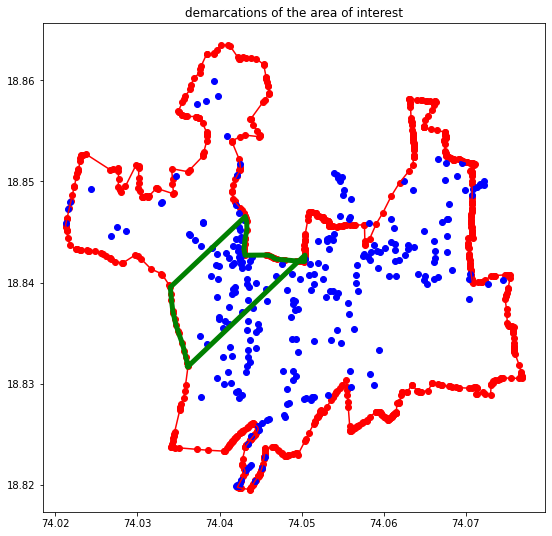

In [94]:
path_to_polygons = 'data/pabal.geojson' # polygon describing area of interest
with open(path_to_polygons) as f:
    gj = geojson.load(f)
# features = gj['features'][0]
points = gj['features'][0]['geometry']['coordinates'][0]

selected_points = points[455:470]
selected_points += points[640:670]
selected_points.append(selected_points[0])
print('the area of interest polygon has', len(points), 'corner points e.g.', points[0])
print('the area of subselection polygon has', len(selected_points), 'corner points e.g.', selected_points[0])

plt.figure(figsize=(9,9))
plt.scatter(x=[pt[0] for pt in points], y=[pt[1] for pt in points], color='red')
plt.plot([pt[0] for pt in points], [pt[1] for pt in points], color='red')
plt.scatter(x=[pt[0] for pt in well_coordinates], y=[pt[1] for pt in well_coordinates], color='blue')
plt.plot([pt[0] for pt in selected_points], [pt[1] for pt in selected_points], lw=5, color='green')

plt.title('demarcations of the area of interest')
plt.show()

In [95]:
# aoi_geom = {
#   "type": "Polygon",
#   "coordinates": [ points ]
# }

aoi_geom = {
  "type": "Polygon",
  "coordinates": [ selected_points ]
}

date_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2019-10-01T00:00:00Z",
    "lte": "2020-05-31T00:00:00Z"
  }
}

date_filter_2 = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gt": "2019-10-15T00:00:00Z",
    "lte": "2020-06-31T00:00:00Z"
  }
}

# we are requesting imagery of type:
item_types = [
    'PSScene4Band',
    'PSScene3Band',
#     'PSOrthoTile',	
#     'REOrthoTile',	
    'REScene',	    
#     'SkySatScene',	
#     'SkySatCollec',
#     'SkySatVideo',	
#     'Landsat8L1G',	
#     'Sentinel2L1C',
]

In [96]:
# build a filter for the aoi and the date range
query = api.filters.and_filter(
    api.filters.geom_filter(aoi_geom),
    date_filter,
)

result_dict = {}
for item_type in item_types:
    # request = {
    #     "item_types" : item_types,
    #     "interval" : "month",
    #     "filter" : date_filter
    # }
    request = api.filters.build_search_request(query, [item_type])
    try: 
        result_dict[item_type] = client.quick_search(request)
    except:
        print('item type', item_type, 'is not available')

print('found image data for', len(result_dict.keys()), 'out of', len(item_types), 'item types (bands)')

found image data for 3 out of 3 item types (bands)


In [104]:
next_url = result_dict[item_types[2]].get().get('_links').get('_next')
# get the asset url for each result returned
len(result_dict[item_types[0]].get().get('features'))
feature = result_dict[item_types[0]].get().get('features')[0]
feature.get('_links')

{'_self': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20200529_051845_1001',
 'assets': 'https://api.planet.com/data/v1/item-types/PSScene4Band/items/20200529_051845_1001/assets/',
 'thumbnail': 'https://tiles.planet.com/data/v1/item-types/PSScene4Band/items/20200529_051845_1001/thumb'}

In [83]:
features = result_dict[item_types[0]].get()
links = features.get('_links')
print(links.get('_self'))
# for link in links:
#     print(link, link.get('_self'))
print('features of type', features.get('type'))
# for feature in features.get('features'):
#     print('keys', feature.keys())
#     feature_id = feature.get('id')
#     if 'assets.analytic:download' in feature.get('_permissions'):
#         print(feature_id, 'can be downloaded:', feature.get('geometry'))
#     else:
#         print('booo!')

https://api.planet.com/data/v1/searches/e02b36d6fdb04bcdba9cf30b9eb59f0e/results?_page=eyJwYWdlX3NpemUiOiAyNTAsICJzb3J0X2J5IjogInB1Ymxpc2hlZCIsICJzb3J0X2Rlc2MiOiB0cnVlLCAic29ydF9zdGFydCI6IG51bGwsICJzb3J0X2xhc3RfaWQiOiBudWxsLCAic29ydF9wcmV2IjogZmFsc2UsICJxdWVyeV9wYXJhbXMiOiB7fX0%3D
features of type FeatureCollection


In [26]:
pabal_ids = [
#     "20200520_051902_1032",
#     "20200520_051901_1032",
#     "20200510_045004_44_2271",
#     "20200510_045002_24_2271",
    "20200426_044843_15_2259",
#     "20200426_044840_93_2259",
#     "20200409_035013_0f21",
#     "20200409_035012_0f21",
#     "20200329_044826_03_2257",
    "20200329_044824_22_2257",
#     "20200303_053910_49_105e",
#     "20200303_051929_1018",
#     "20200303_051928_1018",
#     "20200315_051850_1018",
    "20200315_051849_1018",
#     "20200315_044735_65_2263",
#     "20200315_044733_42_2263",
#     "20200217_051739_1044",
#     "20200217_051738_1044",
    "20200217_035834_1020",
#     "20200217_035833_1020",
#     "20200201_051717_1044",
#     "20200201_051716_1044",
#     "20200117_040410_0f3d",
    "20200101_055723_97_1065",
#     "20200101_055721_89_1065",
#     "20200101_040821_0f36",
#     "20200101_040820_0f36",
    "20191216_055820_06_106b",
#     "20191201_055928_42_1063",
#     "20191201_051629_1009",
    "20191201_051628_1009",
#     "20191119_053519_23_105d",
#     "20191109_060022_51_1069",
    "20191109_060020_49_1069",
#     "20191109_053324_40_1057",
#     "20191109_041331_104e",
    "20191109_041330_104e",
#     "20191005_051654_1032",
    "20191005_051653_1032"
]


In [27]:
for id0 in pabal_ids:
    print(id0)
    id0_url = 'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format('PSScene4Band', id0)

    # Returns JSON metadata for assets in this ID. 
    #Learn more: planet.com/docs/reference/data-api/items-assets/#asset
    result = \
      requests.get(
        id0_url,
        auth=authenticate
      )

    # List of asset types available for this particular satellite image
    print(result.json().keys())
    # This is "inactive" if the "analytic" asset has not yet been activated; otherwise 'active'
    print(result.json()['analytic']['status'])
    
    # Parse out useful links
    links = result.json()[u"analytic"]["_links"]
    self_link = links["_self"]
    activation_link = links["activate"]
    
    asset_activated = False
    while asset_activated == False:
        # Request activation of the 'analytic' asset:
        activate_result = \
          requests.get(
            activation_link,
            auth=authenticate
          )
        activation_status_result = \
          requests.get(
            self_link,
            auth=authenticate
          )
        asset_status = activation_status_result.json()["status"]

        # If asset is already active, we are done
        if asset_status == 'active':
            asset_activated = True
            print("asset is active and ready to download")

    download_link = activation_status_result.json()["location"]
    pl_download(download_link)
    print(download_link)


20200426_044843_15_2259
dict_keys(['analytic', 'analytic_dn', 'analytic_dn_xml', 'analytic_sr', 'analytic_xml', 'basic_analytic', 'basic_analytic_dn', 'basic_analytic_dn_nitf', 'basic_analytic_dn_rpc', 'basic_analytic_dn_rpc_nitf', 'basic_analytic_dn_xml', 'basic_analytic_dn_xml_nitf', 'basic_analytic_nitf', 'basic_analytic_rpc', 'basic_analytic_rpc_nitf', 'basic_analytic_xml', 'basic_analytic_xml_nitf', 'basic_udm', 'basic_udm2', 'udm', 'udm2'])
inactive


KeyboardInterrupt: 

In [13]:
result.json()[]pl_download

dict_keys(['general', 'field'])

In [ ]:
# import time

# asset_activated = False

# while asset_activated == False:
#     # Send a request to the item's assets url
#     res = session.get(assets_url)

#     # Assign a variable to the item's assets url response
#     assets = res.json()

#     # Assign a variable to the visual asset from the response
#     visual = assets["visual"]

#     asset_status = visual["status"]
    
#     # If asset is already active, we are done
#     if asset_status == 'active':
#         asset_activated = True
#         print("Asset is active and ready to download")

# # Print the visual asset data    
# p(visual)

In [46]:
result_dict

{'PSScene3Band': <planet.api.models.Items at 0x114c45fa0>,
 'PSScene4Band': <planet.api.models.Items at 0x114bb94c0>,
 'PSOrthoTile': <planet.api.models.Items at 0x114792310>,
 'REOrthoTile': <planet.api.models.Items at 0x114684d60>,
 'REScene': <planet.api.models.Items at 0x114c729d0>,
 'SkySatScene': <planet.api.models.Items at 0x114c45550>,
 'SkySatVideo': <planet.api.models.Items at 0x114c4ac10>,
 'Landsat8L1G': <planet.api.models.Items at 0x114c4ae20>,
 'Sentinel2L1C': <planet.api.models.Items at 0x114c4ad60>}

In [53]:
result_item = result_dict['PSScene4Band']
# for anobject in result_item:
#     print(type(anobject), anobject)
    
for feature in result_item.get():
    print(feature, type(feature))
# print('coord is a', type(coord), 'object')
# features['properties']

_links <class 'str'>
features <class 'str'>
type <class 'str'>


In [55]:
import sys
sys.getsizeof(result_item) 

48

In [89]:
# len(result_item.get()['features'])
# result_item.get()['features'][0]
# result_item.get()['_links']['_self']
for asset in result_item.get()['features']:
    print(asset['properties']['acquired'], asset['id'], )

2020-10-10T05:18:49.556104Z 20201010_051849_100a
2020-10-10T05:18:48.530596Z 20201010_051848_100a
2020-10-12T04:50:42.286064Z 20201012_045042_28_220b
2020-10-11T05:20:24.250859Z 20201011_052024_0f28
2020-10-11T05:20:23.230071Z 20201011_052023_0f28
2020-10-09T04:55:39.905964Z 20201009_045539_90_2263
2020-10-03T04:50:56.47064Z 20201003_045056_47_220b
2020-10-04T05:18:21.603276Z 20201004_051821_1008
2020-10-04T05:18:20.57305Z 20201004_051820_1008
2020-10-03T05:19:05.82739Z 20201003_051905_1013
2020-09-30T03:21:21.00158Z 20200930_032121_0f36
2020-09-29T03:19:57.954837Z 20200929_031957_104a
2020-09-29T03:19:57.044673Z 20200929_031957_1_104a
2020-09-26T04:54:03.651888Z 20200926_045403_65_222f
2020-09-26T03:22:16.851937Z 20200926_032216_104e
2020-09-25T04:53:11.190454Z 20200925_045311_19_2235
2020-09-14T05:19:23.228489Z 20200914_051923_101b
2020-09-12T05:16:28.799945Z 20200912_051628_1003
2020-09-12T05:16:27.763952Z 20200912_051627_1003
2020-09-10T05:18:10.728358Z 20200910_051810_1006
2020-09

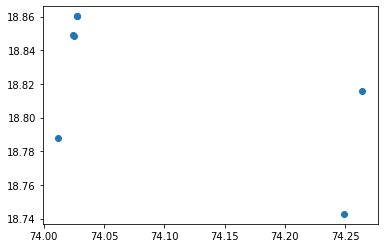

In [80]:
points = [
    [74.10385948140849, 18.769870354677398],
    [73.86469915946421, 18.81561377549817],
    [73.8775031480917, 18.87625462429661],
    [74.11687785101442, 18.830861489467612],
    [74.1151605261982, 18.822585878467617],
    [74.10385948140849, 18.769870354677398]
]


points = [
    [74.02732349714452, 18.860199143490252],
    [74.26433594359852, 18.815535492270826],
    [74.24911840481707, 18.742761679481596],
    [74.01185431796867, 18.787867369983292],
    [74.02446394939268, 18.848828445419468],
    [74.02497067248531, 18.848732192583846],
    [74.02732349714452, 18.860199143490252]]



TypeError: scatter() missing 1 required positional argument: 'y'

In [ ]:
# declare aoi
aoi = {
  "type": "Polygon",
  "coordinates": [
    [
      [-122.54, 37.81],
      [-122.38, 37.84],
      [-122.35, 37.71],
      [-122.53, 37.70],
      [-122.54, 37.81]
    ]
  ]
}

# we are requesting PlanetScope 4 Band imagery
item_types = ['PSScene4Band']
request = api.filters.build_search_request(query, item_types)
# this will cause an exception if there are any API related errors
results = client.quick_search(request)

# items_iter returns an iterator over API response pages
for item in results.items_iter(10):
  # each item is a GeoJSON feature
  sys.stdout.write('%s\n' % item['id'])


In [13]:

# Import helper modules
import json
import requests

# Helper function to printformatted JSON using the json module
def p(data):
    print(json.dumps(data, indent=2))
    
# Setup Planet Data API base URL
URL = "https://api.planet.com/data/v1"

# Setup the session
session = requests.Session()

# Authenticate
session.auth = (PLANET_API_KEY, "")

In [15]:
# Make a GET request to the Planet Data API
res = session.get(URL)
# Response status code
res.status_code

200

In [16]:
# Response Body
res.text

'{"_links": {"_self": "https://api.planet.com/data/v1/", "asset-types": "https://api.planet.com/data/v1/asset-types/", "item-types": "https://api.planet.com/data/v1/item-types/", "spec": "https://api.planet.com/data/v1/spec"}}'

In [17]:
# Print formatted JSON response
p(res.json())

{
  "_links": {
    "_self": "https://api.planet.com/data/v1/",
    "asset-types": "https://api.planet.com/data/v1/asset-types/",
    "item-types": "https://api.planet.com/data/v1/item-types/",
    "spec": "https://api.planet.com/data/v1/spec"
  }
}


In [18]:
# Setup the stats URL
stats_url = "{}/stats".format(URL)

# Print the stats URL
print(stats_url)

https://api.planet.com/data/v1/stats


In [28]:
# Specify the sensors/satellites or "item types" to include in our results
item_types = ["PSScene3Band", "REOrthoTile"]
# Create filter object for all imagery captured between 2013-01-01 and present.
date_filter = {
    "type": "DateRangeFilter", # Type of filter -> Date Range
    "field_name": "acquired", # The field to filter on: "acquired" -> Date on which the "image was taken"
    "config": {
        "lte": "2013-01-01T00:00:00.000Z", # "gte" -> Greater than or equal to
    }
}
# Construct the request.
request = {
    "item_types" : item_types,
    "interval" : "year",
    "filter" : date_filter
}

# Send the POST request to the API stats endpoint
res = session.post(stats_url, json=request)

# Print response
p(res.json())

{
  "buckets": [
    {
      "count": 1353896,
      "start_time": "2009-01-01T00:00:00.000000Z"
    },
    {
      "count": 2153898,
      "start_time": "2010-01-01T00:00:00.000000Z"
    },
    {
      "count": 2493284,
      "start_time": "2011-01-01T00:00:00.000000Z"
    },
    {
      "count": 2716484,
      "start_time": "2012-01-01T00:00:00.000000Z"
    }
  ],
  "interval": "year",
  "utc_offset": "+0h"
}


In [29]:
# Construct the request.
request = {
    "item_types" : item_types,
    "interval" : "month",
    "filter" : date_filter
}

# Send the POST request to the API stats endpoint
res = session.post(stats_url, json=request)

# Print response
p(res.json())

{
  "buckets": [
    {
      "count": 70562,
      "start_time": "2009-02-01T00:00:00.000000Z"
    },
    {
      "count": 68759,
      "start_time": "2009-03-01T00:00:00.000000Z"
    },
    {
      "count": 105176,
      "start_time": "2009-04-01T00:00:00.000000Z"
    },
    {
      "count": 125917,
      "start_time": "2009-05-01T00:00:00.000000Z"
    },
    {
      "count": 135709,
      "start_time": "2009-06-01T00:00:00.000000Z"
    },
    {
      "count": 154552,
      "start_time": "2009-07-01T00:00:00.000000Z"
    },
    {
      "count": 150679,
      "start_time": "2009-08-01T00:00:00.000000Z"
    },
    {
      "count": 135142,
      "start_time": "2009-09-01T00:00:00.000000Z"
    },
    {
      "count": 149489,
      "start_time": "2009-10-01T00:00:00.000000Z"
    },
    {
      "count": 140626,
      "start_time": "2009-11-01T00:00:00.000000Z"
    },
    {
      "count": 117285,
      "start_time": "2009-12-01T00:00:00.000000Z"
    },
    {
      "count": 142922,
      "sta